Just gettin' started!

In [96]:
import pandas as pd
import os
import shutil
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
# Load the FairFace CSV file
df = pd.read_csv("data/fairface_label_train.csv")

In [98]:
df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [99]:
df.shape

(86744, 5)

In [100]:
df['age'].unique()

array(['50-59', '30-39', '3-9', '20-29', '40-49', '10-19', '60-69', '0-2',
       'more than 70'], dtype=object)

In [101]:
# It's highly unlikely that kids under the age of 20 are working in this organization.
df = df[~df['age'].isin(['0-2', '3-9', '10-19'])]

In [102]:
df.shape

(65441, 5)

In [103]:
print(df['race'].unique())
print(df['gender'].unique())

['East Asian' 'Indian' 'White' 'Middle Eastern' 'Latino_Hispanic'
 'Southeast Asian' 'Black']
['Male' 'Female']


In [104]:
# Stratified sampling: race × gender
# samples_per_group = 500

# df_balanced = (
#     df.groupby(['race', 'gender']).apply(
#         lambda x: x.sample(min(len(x), samples_per_group), random_state=42).assign(race=x['race'].iloc[0], gender=x['gender'].iloc[0]),
#         include_groups=False
#     )
#     .reset_index(drop=True)
# )
samples_per_group = 500

grouped = df.groupby(['race', 'gender'], group_keys=False)
df_balanced = pd.concat([
    group.sample(min(len(group), samples_per_group), random_state=42)
    for _, group in grouped
], ignore_index=True)

In [105]:
group_counts = df_balanced.groupby(['race', 'gender']).size().reset_index(name='count')
print(group_counts)

               race  gender  count
0             Black  Female    500
1             Black    Male    500
2        East Asian  Female    500
3        East Asian    Male    500
4            Indian  Female    500
5            Indian    Male    500
6   Latino_Hispanic  Female    500
7   Latino_Hispanic    Male    500
8    Middle Eastern  Female    500
9    Middle Eastern    Male    500
10  Southeast Asian  Female    500
11  Southeast Asian    Male    500
12            White  Female    500
13            White    Male    500


In [106]:
print(df_balanced.columns)

Index(['file', 'age', 'gender', 'race', 'service_test'], dtype='object')


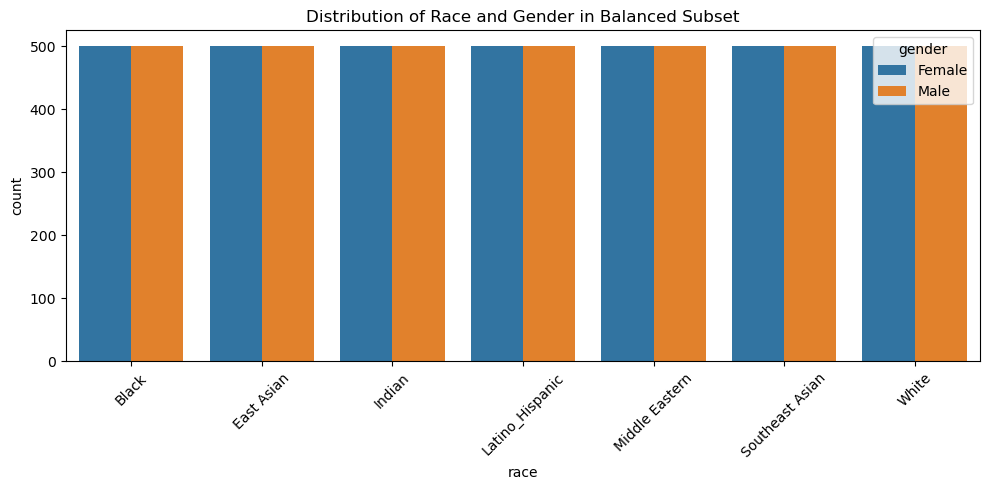

In [107]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_balanced, x='race', hue='gender')
plt.title('Distribution of Race and Gender in Balanced Subset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [108]:
# Save selected subset
df_balanced.to_csv("data/fairface_subset.csv", index=False)

In [115]:
# Copy images to output folder
src_img_dir = "data/fairface-img-margin125-trainval/train"
dst_img_dir = "dataset/human/"
os.makedirs(dst_img_dir, exist_ok=True)

# Strip 'train/' prefix from file column if present
df_balanced['file'] = df_balanced['file'].apply(lambda x: os.path.basename(x))

for img in df_balanced['file']:
    src_path = os.path.join(src_img_dir, img)
    dst_path = os.path.join(dst_img_dir, img)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)